In [1]:
%matplotlib inline
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')

import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import CubicSpline

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 3

# Figsize
cm = 1/2.54  # centimeters in inches

In [2]:
R = 0.5
H = 2

In [3]:
dt = 0.5*0.36
dx = 2.2e-2

t0 = 0*3600
tf = 8*3600
xf = H

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

dx = x[1] - x[0]
# dt = t[1] - t[0]

Nx = len(x) - 1
Nt = len(t) - 1

In [4]:
Tmin = 450
Tmax = 592
eps = 0.4

In [5]:
Tavg = 0.5*(Tmax + Tmin) - 273

rhof = 15.4
muf = 2.53e-5
cpf = 1032
kf = 0.037

d = 0.020
mDot = 0.2
u = mDot/(rhof*eps*np.pi*R**2)

rhos = 2560
cps = 960
ks = 0.48

In [6]:
CFL = dt*u/dx
CFL

0.33822774210792406

In [7]:
T0 = Tmin
Tin = Tmax

Tf = np.zeros((Nx+1, Nt+1))
Ts = np.zeros((Nx+1, Nt+1))

# ICs
Tf[:,0] = T0
Ts[:,0] = T0

# BCs
Tf[0,:] = Tin

In [8]:
alpha = eps*rhof*cpf
beta = eps*kf
gamma = (1-eps)*rhos*cps
betas = ks*(1 - eps)

Rep = rhof*d*eps*u/muf
Pr = cpf*muf/kf
Nu = 2.2 + 0.56*Pr**(1/3)*Rep**(0.65)
a = Nu*kf/d

h = a*6*(1-eps)/d

p = dt*u/dx
q = 2*beta/alpha*0.5*dt/(dx**2)
r = h*dt/alpha

rs = dt*h/gamma
qs = 2*betas*0.5*dt/(gamma*dx**2)

In [9]:
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]
offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p

A = sp.sparse.csr_matrix(A)
# A_inv = sp.sparse.linalg.inv(A)

In [10]:
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]
offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)
# As_inv = sp.sparse.linalg.inv(As)

In [11]:
AA = sp.sparse.block_diag((sp.sparse.linalg.inv(A), sp.sparse.linalg.inv(As)))

C:\Users\MAAL1A\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
C:\Users\MAAL1A\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [12]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
bc1[0] = Tin

In [13]:
for i in range(1,Nt+1):
    
#     bc0 = np.zeros(Nx)
#     bc1 = np.zeros(Nx)

#     bc0[0] = Tin
#     bc1[0] = Tin

#     Ts[i,:] = sp.sparse.linalg.spsolve(As, Ts[i-1,:] + rs*Tf[i-1,:])

#     Tf[i,1:] = sp.sparse.linalg.spsolve(A, Tf[i-1,1:] + (q + p)*bc1 + \
#                 r*Ts[i-1,1:])


    # Solve the entire coupled system in matrix form
    TT = np.concatenate([Tf[1:,i-1] + (q + p)*bc1 + r*Ts[1:,i-1],
                         Ts[:,i-1] + rs*Tf[:,i-1]])
    sol = AA.dot(TT)   
    
    Tf[1:,i] = sol[:Nx]
    Ts[:,i] = sol[Nx:]


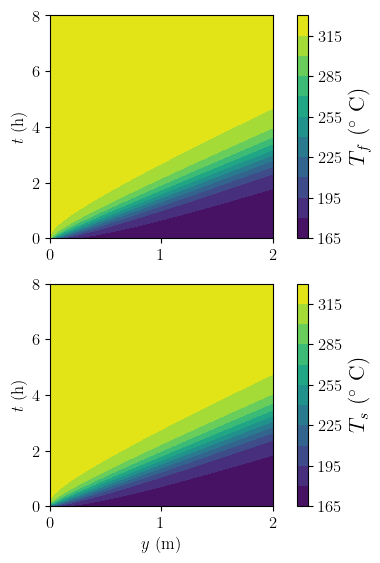

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14*cm,14*cm), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(x, t/3600, Tf.T - 273, 10)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T_f$ ($^\circ$ C)', fontsize=16)
ax1.set_ylabel(r'$t$ (h)')
ax1.set_box_aspect(1)
# ax1.set_xlim([0, 6])

cs2 = ax2.contourf(x, t/3600, Ts.T - 273, 10)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$ ($^\circ$ C)', fontsize=16)
ax2.set_xlabel(r'$y$ (m)')
ax2.set_ylabel(r'$t$ (h)')
ax2.set_box_aspect(1)
# ax2.set_xlim([0, 6])


# plt.colorbar()
# plt.xlim([0, 0.05])
# plt.ylim([0, 10])
#plt.savefig('T_vs_x_t.pdf')

plt.show()

In [15]:
dx0 = int(1.5/dx)

In [16]:
data = np.loadtxt('./validation_Peng.csv', delimiter=";", dtype=float)
tv = data[:,0]
Tv = data[:,1]
Tv[-1]

592.2378716744913

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


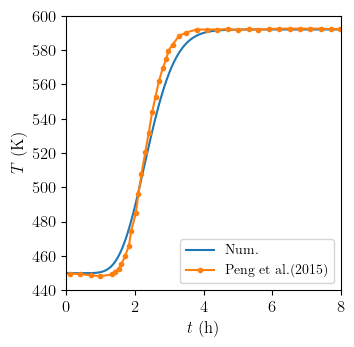

In [17]:
fig, ax = plt.subplots(figsize=(9*cm,12*cm))
plt.plot(t/3600, Ts[dx0,:], tv, Tv, '-o')

plt.gca().set_prop_cycle(None)

# plt.plot(s0hexp[:,0], s0hexp[:,1], 'ks', s0p5h[:,0], s0p5h[:,1], 's', \
#          s1h[:,0], s1h[:,1], 's', s1p5h[:,0], s1p5h[:,1], 's', s2h[:,0], s2h[:,1], 's')

plt.ylim([440, 600])
plt.xlim([0, 8])
plt.legend([r'Num.', r'Peng et al.(2015)'], fontsize=10)
ax.set_box_aspect(1)
ax.set_xlabel(r'$t$ (h)')
ax.set_ylabel(r'$T$ (K)')
# plt.savefig('validation_T_vs_x.pdf', bbox_inches='tight')
plt.savefig('./validation_T_vs_x_Peng.eps', bbox_inches='tight', format='eps')
plt.show()